# Descente de gradient 

Au cours de la séance précédente, nous avons vu deux méthodes différentes pour trouver le jeu de paramètres qui minimise la MSE, c'est à dire pour trouver la meilleure calibration de notre droite de régression. 

Aujourd'hui nous allons étudier une troisième méthode, plus adaptée pour les larges jeux de données, en particulier à plusieurs dimension : **la descente de gradient**.

Cette technique est fondamentale, non seulement pour la régression linéaire mais dans un grand nombre d'algorithmes de machine learning. 

In [ ]:
%load_ext autoreload
import numpy as np 
import matplotlib.pyplot as plt
from drawdata import ScatterWidget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Génération du jeu de données

In [7]:
widget = ScatterWidget()
widget

ScatterWidget()

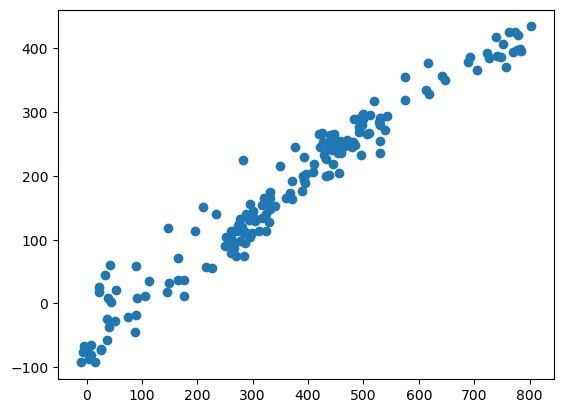

In [14]:
X, y = widget.data_as_X_y

plt.scatter(X, y);

Rappel : forme de la fonction de coût

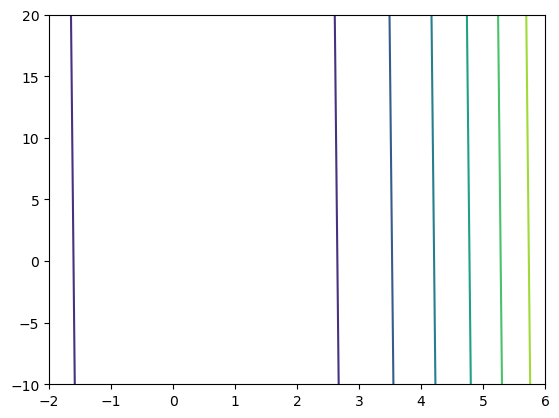

In [20]:
from utils import generate_mse_grid

# grille de paramètres
intercept_vals = np.linspace(-10, 20, 100)
slope_vals = np.linspace(-2, 6, 100)

MSE_grid = generate_mse_grid(X, y, intercept_vals, slope_vals)

plt.contour(slope_vals, intercept_vals, MSE_grid)

In [28]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=True)
model.fit(np.hstack([np.ones(177),X]), y)
model.coef_

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

In [24]:
X.flatten().shape

(177,)

1. Fonctionnement de la descente de gradient 

2. Influence du *learning rate*

> Maintenant que l'on a vu comment bien paramètrer un modèle de régression linéaire, l'enjeu est de pouvoir l'utiliser et de s'assurer qu'il est performant. Ce sera l'objet du cours de demain : **évaluer un modèle linéaire**

Ressources : 

- Cette [excellente vidéo](https://www.youtube.com/watch?v=IHZwWFHWa-w) de 3 Blue 1 Brown, toute la chaîne vaut le détour
- L'idée du widget vient de [cette vidéo](https://www.youtube.com/watch?v=yLz1NELcIM0) de Probabl, un spin-off de scikit-learn qui diffuse des vidéos d'explication sur le ML
- La documentation de scikit-learn est très bien faite

- Toujours dans le registre des vidéos Youtube, vous pouvez aller voir : 
  - 3Blue1Brown
  - MachineLearnia
  - Statquest